In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy

2024-03-06 01:20:48.061918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 01:20:48.061989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 01:20:48.063574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 01:20:48.071226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 01:20:48.689352: W tensorflow/compiler/tf2

### Generating the dataset

In [2]:
omega_m_0 = np.linspace(0.1, 0.4, 40)
H_0 = np.linspace(65, 80, 15)
N = np.linspace(0, -12, 50)

In [3]:
av, bv, cv = np.meshgrid(N, omega_m_0, H_0)
av = av.T.reshape(-1, 1)
bv = bv.T.reshape(-1, 1)
cv = cv.T.reshape(-1, 1)

X = np.concatenate([av, bv, cv], axis=1)

print("X.shape =", X.shape)

X.shape = (30000, 3)


#### The system of equations:

$\Omega_i' = 3(\Pi - \gamma_i)\Omega_i $

where, $i = r, m, \Lambda$ 

---

#### Simplifying $\Pi$:
$\Pi = \sum_i \Omega_i \gamma_i \quad (i = r, m, \Lambda)$

$\Pi = \Omega_r \gamma_r + \Omega_m \gamma_m + \Omega_\Lambda \gamma_\Lambda \quad (\gamma_r = 4/3, \gamma_m = 1, \gamma_\Lambda = 0)$

Which simplifies to: $\,$
$3\Pi = 4\Omega_r + 3\Omega_m \qquad \rightarrow Eq(1) $ 

---

#### For $\Omega_r$:
$\Omega_r' = 3(\Pi - \gamma_r)\Omega_r$

$\Omega_r' = (3\Pi - 4)\Omega_r \qquad \rightarrow Eq(2)$

#### For $\Omega_m$:
$\Omega_m' = 3(\Pi - \gamma_m)\Omega_m$

$\Omega_m' = (3\Pi - 3)\Omega_m \qquad \rightarrow Eq(3)$

#### For $\Omega_\Lambda$:
$\Omega_\Lambda' = 3(\Pi - \gamma_\Lambda)\Omega_\Lambda$

$\Omega_\Lambda' = 3\Pi\Omega_\Lambda \qquad \rightarrow Eq(4)$


In [4]:
def RHS(omega_i, lna, gamma=0):
    omega_r, omega_m, omega_l, H = omega_i
    three_pi = 3 * omega_m + 4 * omega_r

    return [
        (three_pi - 4) * omega_r,
        (three_pi - 3) * omega_m,
        (three_pi) * omega_l,
        -0.5 * three_pi * H
    ]

def solve(lna, omega_m, H_0):
    omega_r = 0.0001
    omega_l = 1 - omega_r - omega_m
    
    y0 = [omega_r, omega_m, omega_l, H_0]
    
    result = scipy.integrate.odeint(RHS, y0, lna)
    return result

In [5]:
Y = []
for i in omega_m_0:
    for j in H_0:
        result = solve(N, i, j)
        Y.extend(result)
Y = np.array(Y)

X = []
for i in omega_m_0:
    for j in H_0:
        for t in N:
            X.append([t, i, j])
X = np.array(X)

In [6]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))
Y2 = scaler.fit_transform(Y)

In [7]:
import random
def split(X, Y, percent):
    n = int(percent * len(X))
    index = random.sample(range(len(X)),n)
    X_learn = []
    Y_learn = []
    for i in index:
        X_learn.append(X[i])
        Y_learn.append(Y[i])
    X_val = np.delete(X,index, axis=0)
    Y_val = np.delete(Y,index, axis=0)
    
    X_learn = np.array(X_learn)
    Y_learn = np.array(Y_learn)
    return X_learn, Y_learn, X_val, Y_val

X_learn, Y_learn, X_val, Y_val = split(X, Y2, 0.8)

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(150, input_shape=(3,), activation='sigmoid'),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(4)
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), loss='mse')

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 150)               600       
                                                                 
 dense_6 (Dense)             (None, 150)               22650     
                                                                 
 dense_7 (Dense)             (None, 150)               22650     
                                                                 
 dense_8 (Dense)             (None, 150)               22650     
                                                                 
 dense_9 (Dense)             (None, 4)                 604       
                                                                 
Total params: 69154 (270.13 KB)
Trainable params: 69154 (270.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
history = model.fit(X_learn, Y_learn, epochs=200, validation_data=(X_val, Y_val))

Epoch 1/200


2024-03-06 01:23:44.945821: I external/local_xla/xla/service/service.cc:168] XLA service 0x789a253c4b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-06 01:23:44.945853: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-03-06 01:23:44.951382: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-06 01:23:44.961278: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709668424.991479  199966 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 [==============================] - 2s 2ms/step - loss: 0.0465 - val_loss: 0.0215
Epoch 2/200
750/750 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0155
Epoch 3/200
750/750 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0137
Epoch 4/200
750/750 [==============================] - 1s 2ms/step - loss: 0.0109 - val_loss: 0.0069
Epoch 5/200
750/750 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 6/200
750/750 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0047
Epoch 7/200
750/750 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0050
Epoch 8/200
750/750 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0078
Epoch 9/200
750/750 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0040
Epoch 10/200
750/750 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0032
E

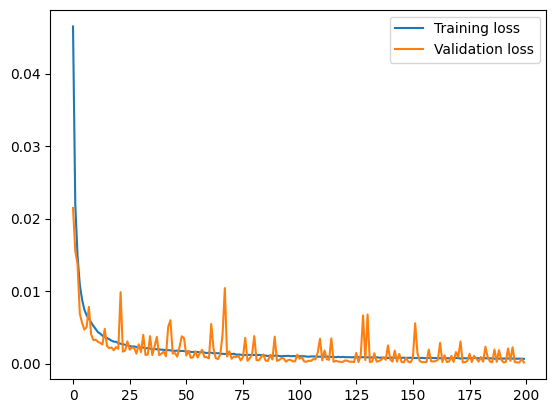

In [14]:
plt.figure()
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.show()

#### Model performance for $\Omega_{m,0} = 0.4, H_0 = 68$

In [20]:
X_test = []
for t in N: X_test.append([t, 0.4, 68])
Y_pred = scaler.inverse_transform(model.predict(X_test))
Y_test = solve(N, 0.4, 68)

2/2 [==============================] - 0s 2ms/step


Text(-8.5, 0.1, '$\\Omega_{\\Lambda}$')

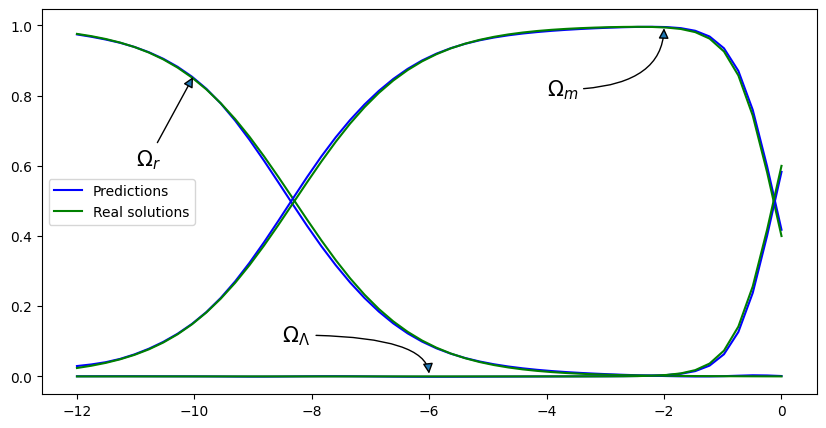

In [43]:
plt.figure(figsize=(10, 5))

plt.plot(N, Y_pred[:, 0], color='blue')
plt.plot(N, Y_test[:, 0], color='green')

plt.plot(N, Y_pred[:, 1], color='blue')
plt.plot(N, Y_test[:, 1], color='green')

plt.plot(N, Y_pred[:, 2], color='blue')
plt.plot(N, Y_test[:, 2], color='green')

plt.legend(['Predictions', 'Real solutions'])

plt.annotate('$\Omega_m$', xy=(-2,1), xytext=(-4,0.8), size=15,
           arrowprops=dict(arrowstyle='-|>', connectionstyle="angle3,angleA=0,angleB=-90"))

plt.annotate('$\Omega_r$', xy=(-10,0.86), xytext=(-11,0.6),size=15,
           arrowprops=dict(arrowstyle='-|>'))

plt.annotate('$\Omega_{\Lambda}$', xy=(-6,0), xytext=(-8.5,0.1),size=15,
           arrowprops=dict(arrowstyle='-|>', connectionstyle="angle3,angleA=0,angleB=90"))